<a href="https://colab.research.google.com/github/DarshanPatel0919/Deep-Learning/blob/master/LabAssignment3_201701436.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Darshan Patel

201701436

Deep Learning

Lab3 - Back Propogation

#**Modules**

In [ ]:
import tensorflow as tf
import numpy as np
from time import time 
from matplotlib import pyplot as plt
from IPython.display import clear_output

#**Activation Functions and Helper Functions**

In [ ]:
### Different activation functions
relu = lambda x : tf.nn.relu(x)
tanh = lambda x : tf.nn.tanh(x)
sigmoid = lambda x : tf.math.sigmoid(x)
softmax = lambda x : tf.nn.softmax(x,axis=0)

### Derivatives of activation functions
drelu = lambda x : tf.math.floordiv(tf.math.add(tf.math.sign(x),tf.Variable(1,dtype=tf.float32)),tf.Variable(2,dtype=tf.float32))
dtanh = lambda x : tf.math.divide(tf.Variable(1,dtype=tf.float32),tf.math.multiply(tf.math.cosh(x),tf.math.cosh(x)))
dsigmoid = lambda x : tf.math.multiply(sigmoid(x) , tf.math.subtract(tf.Variable(1,dtype=tf.float32) , sigmoid(x)))
dsoftmax = lambda x : tf.math.multiply(softmax(x) , tf.math.subtract(tf.Variable(1,dtype=tf.float32) , softmax(x)))

### Function Convert the labels into one hot vectors
def classification_Output(y,c):
  Y = np.zeros((c, tf.shape(y)[0]))
  for i in range(tf.shape(y)[0]):
    label = y[i]
    Y[label][i] = 1
  return tf.convert_to_tensor(Y,dtype=tf.float32)

#**Neural Network Functions**

In [ ]:
### Class for neural network so that multiple neural networks can be stored in different objects simultaneously
### L => Layers with number of nodes
### l => Number of hidden layers + Output layer
### W => Weight matrices
### B => Bias matrices
### F => Activations for each layer
### Fd => Derivatives for activations
### Z => Zi represents Z for ith layers for given iteration, Z[0] = Z of first layer
### A => Ai represents A for ith layers for given iteration, A[0] = input, A[1] = A of first layer

class nn:
  def __init__(self,features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts, seeds = 1):
    self.L = [features] + layers + [classes]
    self.l = len(self.L) - 1
    self.W = [tf.Variable(weight_consts[i]*tf.random.normal([self.L[i+1],self.L[i]], weight_means[i], weight_stddevs[i], tf.float32, seed=seeds)) for i in range(self.l)]
    self.B = [tf.Variable(bias_consts[i]*tf.random.normal([self.L[i+1],1],bias_means[i],bias_stddevs[i],tf.float32,seed=seeds)) for i in range(self.l)]
    self.F = activations
    self.Fd = derivatives
    self.Z = [tf.Variable(0,dtype=tf.float32) for i in range(self.l)]
    self.A = [tf.Variable(0,dtype=tf.float32) for i in range(self.l + 1)]

  def forward_prop_update(self,input):
    self.A[0] = tf.identity(input)
    for i in range(self.l):
      self.Z[i] = tf.math.add(tf.linalg.matmul(self.W[i],self.A[i]) , self.B[i])  ### Formula for calculating Z of (i+1)th layer
      self.A[i+1] = tf.identity(self.F[i](self.Z[i]))  ### Formula for calculating A of (i+1)th layer
      
  def backward_prop_update(self,output,alpha_w,alpha_b):
    m = tf.cast(tf.shape(output)[1],dtype=tf.float32) 
    dZ = tf.math.subtract(self.A[self.l] , output)  ### dZ for output layer

    for i in range(self.l - 1, -1, -1):
      ### dW, dB for current layer
      dW = tf.math.divide(tf.linalg.matmul(dZ,self.A[i],transpose_b=True) , m) 
      dB = tf.math.reduce_mean(dZ, axis=1, keepdims=True) ### dB for (i+1)th layer
      
      ### Calculating dZ for next layer in back-propogation
      if i > 0 : 
        dA = tf.linalg.matmul(self.W[i],dZ,transpose_a=True)
        dZ = tf.math.multiply(dA, self.Fd[i-1](self.Z[i-1]))

      ### Updating W, B of current layer  
      self.W[i] = tf.subtract(self.W[i], tf.math.scalar_mul(alpha_w,dW))
      self.B[i] = tf.subtract(self.B[i], tf.math.scalar_mul(alpha_b,dB))
      
  def mini_batch_train(self,input,output,epochs,batch_size,alpha_w,alpha_b,xt,yt):
    m = tf.shape(input)[1]
    x = tf.split(input, num_or_size_splits=int(m//batch_size), axis=1)
    y = tf.split(output, num_or_size_splits=int(m//batch_size), axis=1)
    acc_train, acc_test = [], []
    for ep in range(epochs):
      for batch_no in range(len(x)):
        self.forward_prop_update(x[batch_no])
        self.backward_prop_update(y[batch_no],alpha_w,alpha_b)
      acc_train.append(self.prediction_accuracy(input,output))
      acc_test.append(self.prediction_accuracy(xt,yt))
    plt.plot(acc_train,label='train')
    plt.plot(acc_test,label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy %')
    plt.legend(loc='best')
    plt.show()

  def plot_array(self,X):
    fig = plt.figure()
    for i in range(self.l):
      ax = fig.add_subplot(1, self.l, i+1)
      ax.matshow(X[i])
    plt.show()
  
  def forward_prop_predict(self,input):
    A = tf.identity(input)
    for i in range(self.l):
      Z = tf.math.add(tf.linalg.matmul(self.W[i],A) , self.B[i]) 
      A = tf.identity(self.F[i](Z))
    return A  ### Note : Returns the labels in one hot vector form
  
  def prediction_accuracy(self,input,output):
    ### Predicting output using forward propogation
    A = self.forward_prop_predict(input)

    ### Extracting labels  
    prediction = tf.argmax(A,axis=0)
    label = tf.argmax(output,axis=0)

    ### Calculating Accuracy using True-Positives in confusion matrix
    conf = tf.math.confusion_matrix(label,prediction)
    acc = tf.linalg.trace(conf)*100/tf.shape(input)[1]
    return acc

#**MNIST : Digit Classification**

In [ ]:
data = tf.keras.datasets.mnist.load_data('mnist.npz')

In [ ]:
### Extracting the dataset into inputs and labels

features, m = data[0][0].shape[1]*data[0][0].shape[2] , data[0][0].shape[0]
classes = 10  #Classification Problem

### Reshape 784*60000
x = tf.transpose(tf.reshape(tf.Variable(data[0][0], dtype=tf.float32), shape=(m, features))) ## x_train 
xt = tf.transpose(tf.reshape(tf.Variable(data[1][0], dtype=tf.float32), shape=(10000, features))) ## x_test

### Convert to one hot vectors
y = classification_Output(tf.Variable(data[0][1]), classes) ## y_train
yt = classification_Output(tf.Variable(data[1][1]), classes) ## y_test


### Slicing the input

slicer = m
x = tf.Variable(x[:,:slicer])
y = tf.Variable(y[:,:slicer])

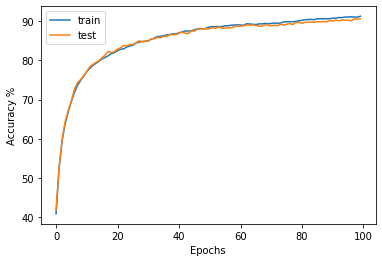

Network trained in : 6.68893430630366 Minutes 41.336058378219604 Seconds


In [ ]:
##### Hyper parameters

l = 3 # Number of hidden layers
layers = [256,128,64] # Nodes for each hidden layer

activations = [sigmoid]*l + [softmax]  # Activation functions
derivatives = [dsigmoid]*l + [dsoftmax]  # Derivatives for activations

epochs = 100
batch_size = 300

alpha_w = tf.Variable(0.1,dtype=tf.float32) # learning parameter for W
alpha_b = tf.Variable(0.1,dtype=tf.float32) # learning parameter for B

weight_means = [0]*(l+1) 
weight_stddevs = [1]*(l+1)
weight_consts = [1]*(l+1)

bias_means = [0]*(l+1)
bias_stddevs = [1]*(l+1)
bias_consts = [1]*(l+1)

### Random Initialization
tf.random.set_seed(1)
NN = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)

### Training network using train data
tic = time()
NN.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)
toc = time()
t = int(toc - tic)
min,sec = t//60, t%60
print("Network trained in :",min,"Minutes",sec,"Seconds")

Observation:

1. Epochs

  *   As the number of epochs increase accuracy increases
  *   Accuracy saturates at 91%
  *   We can say that data is homogenous(well-spread) since accuracy of train and test set is almost the same throughout the training 


2. Varying Batchsize
  *   Batch size : 300 gives the best results (for 600 accuracy is 87%)
  *   As we increase the batch size training time is lesser, for very big batchsizes accuracy may degrade

3. Varying Functions
  *   Other functions in hidden layers are giving very bad results 
  *   In the output layer softmax is used because it is a multiclass classification







Weights


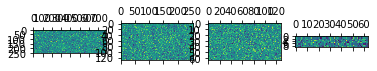

In [ ]:
### Visualizing Weights 
print('Weights')
NN.plot_array(NN.W)

Observation :

*   Since This is a very dense network understanding it's behaviour by visualizing weight matrices is very hard

*   Values of weights are not showing any patterns or relation with nodes

*   One observation we can put here is that respective nodes in output layers for each classes will be brighter for those pixels of class which are brighter in actual number 




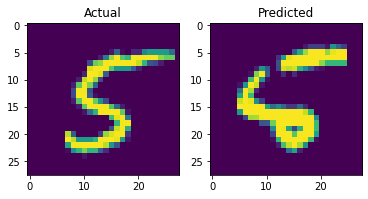

Actual Digit : 5
Predicted Digit : 5


In [ ]:
### Visualising the layer output with random example
### Choose a random image from x_test data

i = int(tf.random.uniform([],maxval=9999))
xi = data[1][0][i]
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.title.set_text('Actual')
ax.imshow(xi)

### Feeding image into neural network
xi = tf.transpose(tf.reshape(tf.Variable(xi, dtype=tf.float32), shape=(1, features))) 
A = NN.forward_prop_predict(xi)
label = tf.argmax(A)[0]

x_pred = data[1][0][np.where(data[1][1]==label)[0]][0]
ax = fig.add_subplot(1,2,2)
ax.title.set_text('Predicted')
ax.imshow(x_pred)
plt.show()


print('Actual Digit :', data[1][1][i])
tf.print("Predicted Digit :",label)

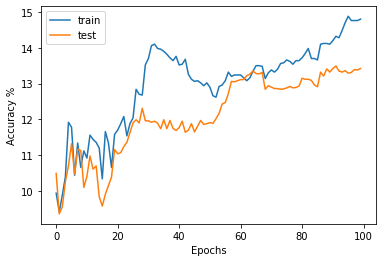

Accuracy : 13.42 %


In [ ]:
##### Changing value of alpha

alpha_w = tf.Variable(0.01,dtype=tf.float32) # learning parameter for W
alpha_b = tf.Variable(0.01,dtype=tf.float32) # learning parameter for B
batch_size = 600

NN1_1 = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)
NN1_1.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)

Observation : 

*   If the value of alpha is very small, change in weights after each iteration will be so slow so that the neural network will not be trained properly and hence the accuracy will fall  

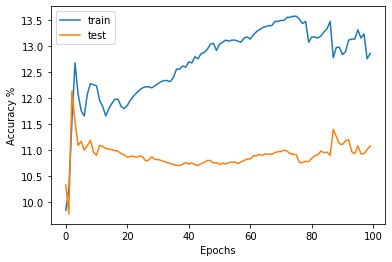

In [ ]:
##### Changing activation functions

alpha_w = tf.Variable(0.1,dtype=tf.float32) # learning parameter for W
alpha_b = tf.Variable(0.1,dtype=tf.float32) # learning parameter for B
batch_size = 600

activations = [tanh]*l + [softmax]  # Activation functions
derivatives = [dtanh]*l + [dsoftmax]  # Derivatives for activations

NN1_2 = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)
NN1_2.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)

* Even Replacing sigmoid with tanh also results in bad accuracy



#**CIFAR10 : Image classification**

In [ ]:
data = tf.keras.datasets.cifar10.load_data()

In [ ]:
### Extracting the dataset into inputs and labels

x = data[0][0]
dim = x.shape
features, m = dim[1]*dim[2]*dim[3] , dim[0]
classes = 10  #Classification Problem

### Reshape 784*60000
x = tf.transpose(tf.reshape(tf.Variable(data[0][0], dtype=tf.float32), shape=(m, features))) ## x_train 
xt = tf.transpose(tf.reshape(tf.Variable(data[1][0], dtype=tf.float32), shape=(10000, features))) ## x_test

### Convert to one hot vectors

y = tf.Variable([data[0][1][i][0] for i in range(m)],dtype=tf.int32)
yt = tf.Variable([data[1][1][i][0] for i in range(10000)],dtype=tf.int32)

y = classification_Output(y, classes) ## y_train
yt = classification_Output(yt, classes) ## y_test

##### Hyper parameters

l = 3 # Number of hidden layers
layers = [256,128,64] # Nodes for each hidden layer

activations = [softmax]*l + [softmax]  # Activation functions
derivatives = [dsoftmax]*l + [dsoftmax]  # Derivatives for activations

slicer = m
epochs = 100
batch_size = 500

alpha_w = tf.Variable(0.1,dtype=tf.float32) # learning parameter for W
alpha_b = tf.Variable(0.1,dtype=tf.float32) # learning parameter for B

weight_means = [0]*(l+1) 
weight_stddevs = [1]*(l+1)
weight_consts = [1]*(l+1)

bias_means = [0]*(l+1)
bias_stddevs = [1]*(l+1)
bias_consts = [1]*(l+1)

### Slicing the input
x = tf.Variable(x[:,:slicer])
y = tf.Variable(y[:,:slicer])

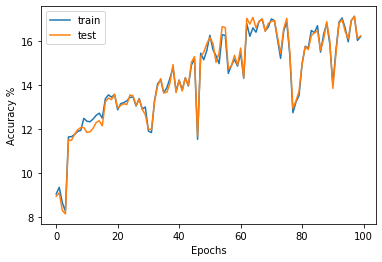

In [ ]:
NN2 = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)
NN2.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)

Observation : For all softmax activation we are not getting any accuracy



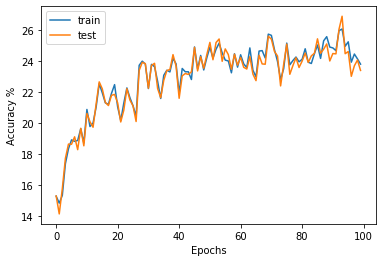

In [ ]:
##### Changing activation functions and layers

layers = [128,128,128]

activations = [sigmoid]*l + [softmax]  # Activation functions
derivatives = [dsigmoid]*l + [dsoftmax]  # Derivatives for activations

NN2_1 = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)
NN2_1.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)

Observation : Using Sigmoid in hidden layers gives better accuracy but still not enough

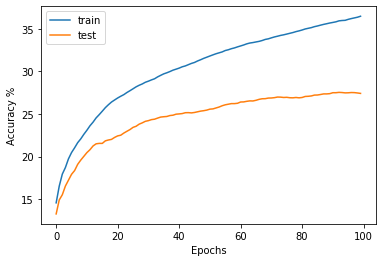

In [ ]:
### Normalise the data

x1 = tf.transpose(tf.reshape(tf.Variable(data[0][0], dtype=tf.float32), shape=(m, features))) ## x_train 
x1 = tf.math.divide(tf.math.subtract(x1 , tf.math.reduce_mean(x1,axis=0)),tf.math.reduce_std(x1,axis=0))
x , xt = tf.split(x1, [m-10000,10000], 1)

y = tf.Variable([data[0][1][i][0] for i in range(m-10000)],dtype=tf.int32)
yt = tf.Variable([data[0][1][i+m-10000][0] for i in range(10000)],dtype=tf.int32)

y = classification_Output(y, classes) ## y_train
yt = classification_Output(yt, classes) ## y_test

NN2_2 = nn(features, classes, layers, activations,  derivatives, weight_means, weight_stddevs, weight_consts, bias_means, bias_stddevs, bias_consts)
NN2_2.mini_batch_train(x,y,epochs,batch_size,alpha_w,alpha_b,xt,yt)

Observation:

*   We can see that by normalizing the data accuracy for predicting the training data increases with the number of epochs, in graoh we can see that it is not saturating hence we can predict that for Epochs = 500 it can reach 85% accuracy 
*   But still this is not good enough, since accuracy for training data is getting saturated at 25%

*   Using above observations we can say that Varying the Batchsizes or Activation functions are not affecting the accuracy in any better way
*   **But We understand an intresting fact that By changing the input's values by applying some sort of transformations, we can convert features into trainable data for the neural networks, This could be a huge department of research in Deep Learning i.e Idea of CNN, etc.** 







Weights


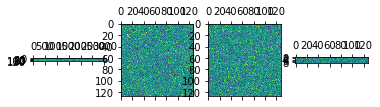

In [ ]:
### Visualizing Weights and Biases
print('Weights')
NN.plot_array(NN2_2.W)

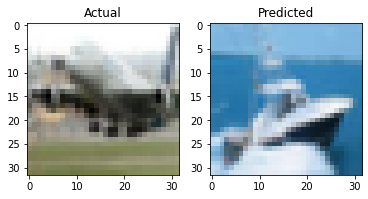

Actual Image Class : 0
Predicted Image Class : 8


In [ ]:
### Visualising the layer output with random example
### Choose a random image from x_test data

i = int(tf.random.uniform([],maxval=39999))
xi = data[0][0][i]
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.title.set_text('Actual')
ax.imshow(xi)

### Feeding image into neural network
xi = tf.transpose(tf.reshape(tf.Variable(xi, dtype=tf.float32), shape=(1, features))) 
xi = tf.math.divide(tf.math.subtract(xi , tf.math.reduce_mean(xi)),tf.math.reduce_std(xi))
A = NN2_2.forward_prop_predict(xi)
label = tf.argmax(A)[0]

x_pred = data[0][0][np.where(data[0][1]==label)[0]][0]
ax = fig.add_subplot(1,2,2)
ax.title.set_text('Predicted')
ax.imshow(x_pred)
plt.show()


print('Actual Image Class :', data[0][1][i][0])
tf.print("Predicted Image Class :",label)

There are very much mismatches in predictions